## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
# import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### TODO: Google Cloud data access and opening

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

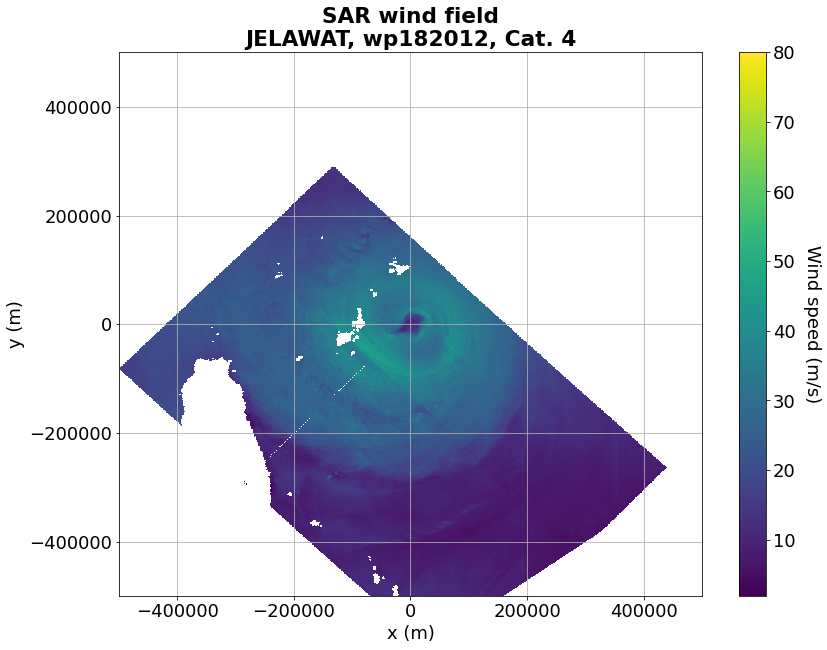

In [3]:
### PLOTTING WIND FIELDS 
# Print the first TC of the Dataset
du.plot_wind_field(ds_all, time_idx=1)

# Print all the TCs named 'HECTOR'
# storm_name = 'HECTOR'
# print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
# for time_idx in find_time_idx(ds_all, storm_name):
#     plot_wind_field(ds_all, time_idx)

In [14]:
### CONVERT TO POLAR R* GRID AND CONCATENATE
listOfDatasets  = []
res_ref         = 10

n_total = len(ds_all['time'])
n_test  = 50

for time_idx in tqdm(range(n_test)):
    ds_polar  = du.get_ds_in_polar_r_star_coords_v02(ds_all, time_idx, res_ref=res_ref)
    listOfDatasets.append(ds_polar)

ds_polar_all = xr.concat(listOfDatasets, dim='time')

100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


In [15]:
ds = ds_polar_all

In [6]:
### DASK VERSION TO CONVERT TO POLAR R* AND CONCATENATE - DOESN'T WORK

# %%time
# import importlib
# importlib.reload(du)

# ### Choose resolution
# res_ref = 10
# n_total = len(ds_all['time'])
# n_test  = 2
# tasks   = [du.get_ds_in_polar_r_star_coords_v02(ds_all, time_idx, res_ref=res_ref) for time_idx in range(n_test)]
# with ProgressBar():
#     z = da.compute(tasks, scheduler='processes', num_workers=32)
#     # da.compute(tasks, scheduler='processes')

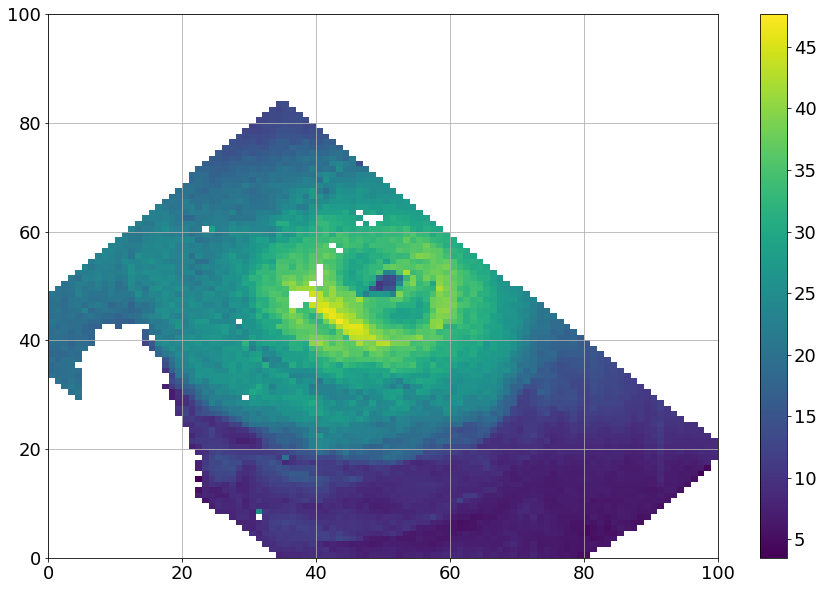

In [7]:
plt.pcolormesh(ds_polar_all.isel(time=1)['wind_speed']);plt.colorbar();plt.grid()

In [16]:
### COVARIANCE MATRIX IN POLAR COORDINATES

ds_polar_stack = ds_polar_all.stack(dimensions={'pixel': ('r*', 'th')})
x_Ex           = ds_polar_stack['wind_speed'] - ds_polar_stack.mean(dim='pixel', skipna=True)['wind_speed']  # X - mean(X) for each pixel
# Expand dimension to prepare matrix multiplication
x_Ex_expanded   = x_Ex.assign_coords(y='vector_dim')
x_Ex_expanded   = x_Ex_expanded.expand_dims('vector_dim', axis=2)
print('x_Ex_expanded shape: ', x_Ex_expanded.shape)
x_Ex_transposed = x_Ex_expanded.transpose('time', 'vector_dim', 'pixel')
print('x_Ex_transposed shape: ', x_Ex_transposed.shape)
# Matrix multiplication
a       = np.array(x_Ex_expanded)
b       = np.array(x_Ex_transposed)
product = np.einsum('ijk, ikl -> ijl', a, b) # input: (20, 10 000, 1) and (20, 1, 10 000) -> output: (20, 10 000, 10 000)
print('product shape: ', product.shape)
# Mean on time to get covariance
cov_mat = np.nanmean(product, axis=0)
print('cov_mat shape: ', cov_mat.shape)

x_Ex_expanded shape:  (50, 10000, 1)
x_Ex_transposed shape:  (50, 1, 10000)
product shape:  (50, 10000, 10000)
cov_mat shape:  (10000, 10000)


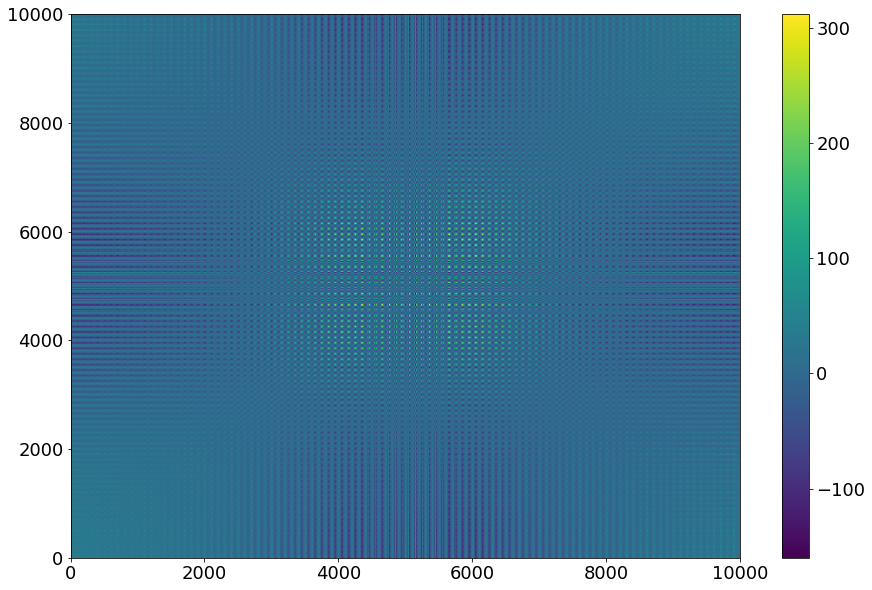

In [17]:
plt.pcolormesh(cov_mat);plt.colorbar()

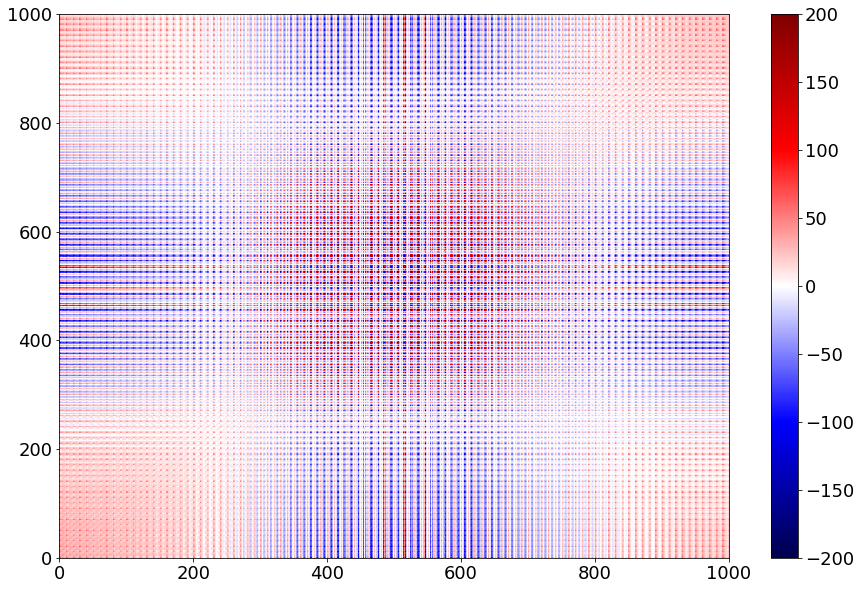

In [23]:
plt.pcolormesh(cov_mat[::10, ::10], cmap='seismic', vmin=-200, vmax=200);plt.colorbar()

In [25]:
plt.hist(cov_mat[::10, ::10], bins=50)

(array([[0., 0., 6., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-159.49628356, -150.39500296, -141.29372237, -132.19244178,
        -123.09116119, -113.9898806 , -104.88860001,  -95.78731942,
         -86.68603882,  -77.58475823,  -68.48347764,  -59.38219705,
         -50.28091646,  -41.17963587,  -32.07835527,  -22.97707468,
         -13.87579409,   -4.7745135 ,    4.32676709,   13.42804768,
          22.52932827,   31.63060887,   40.73188946,   49.83317005,
          58.93445064,   68.03573123,   77.13701182,   86.23829241,
          95.33957301,  104.4408536 ,  113.54213419,  122.64341478,
         131.74469537,  140.84597596,  149.94725655,  159.04853715,
         168.14981774,  177.25109833,  186.35237892,  195.45365951,
         204.5549401 ,  213.65622069,  222.75750129,  231.85878188,
   

Error in callback <function flush_figures at 0x7f57959e50d0> (for post_execute):


KeyboardInterrupt: 

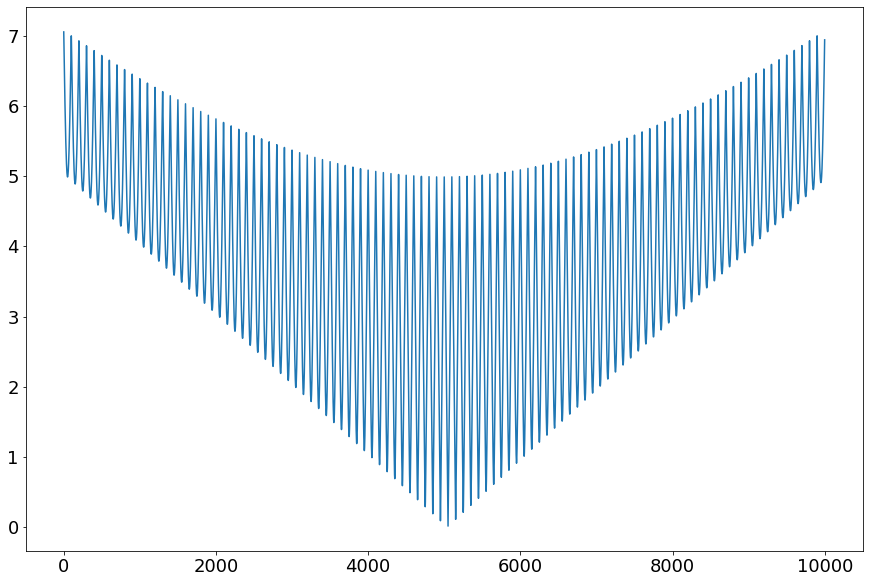

In [12]:
plt.plot(x_Ex['r*_grid'])

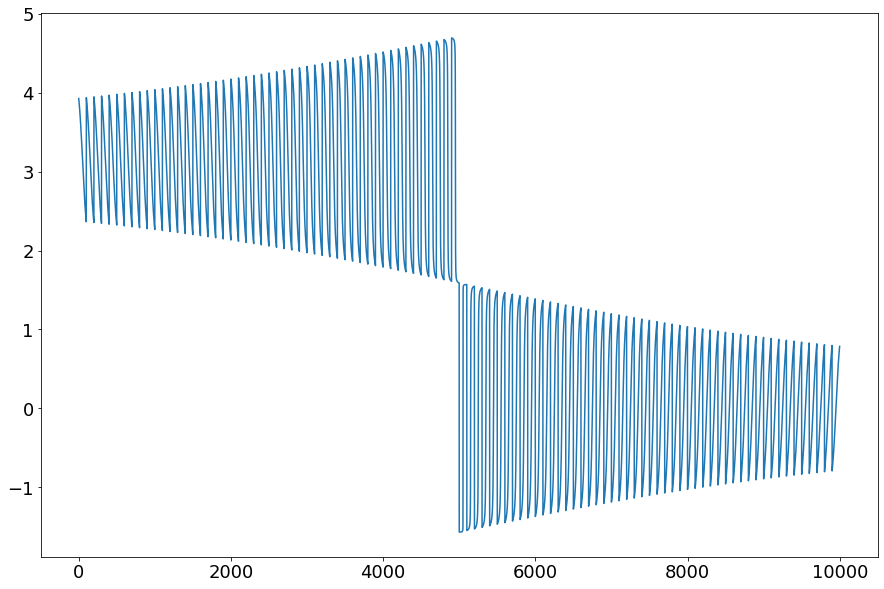

In [13]:
plt.plot(x_Ex['th_grid'])

In [ ]:
plt.pcolormesh(ds_polar_all.mean(dim='time', skipna=True)['wind_speed']);plt.colorbar()

In [ ]:
### OLD VERSION FOR INTERPOLATING ON (R*, TH) GRID

# import importlib
# importlib.reload(du)

# # Create reference polar axis
# r_star_ref_ax = du.create_reference_axis(size=4, interval=0.005)
# theta_ref_ax  = du.create_reference_axis(size=360, interval=0.5)

# # Convert ds to polar coordinates
# ds_polar = du.get_ds_in_polar_r_star_coords(r_star_ref_ax, theta_ref_ax, ds_all, time_idx=2)
# ds_polar

# # Plot polar
# # ds    = ds_polar.isel(time=0)
# # plt.subplot(projection = "polar")
# # r, th = np.meshgrid(ds['r*'], ds['th'], indexing='ij') # keep (r, th) order
# # plt.pcolormesh(th, r, ds['wind_speed']);plt.colorbar()

# # Cartesian plot
# ds   = ds_polar.isel(time=0)
# print(ds['wind_speed'].shape)
# r, th = np.meshgrid(ds['r*'], ds['th'], indexing='ij') # keep (r, th) order
# th   = np.deg2rad(th)
# x, y = du.pol2cart(r, th)
# plt.pcolormesh(x, y, ds['wind_speed']);plt.colorbar();plt.grid()

In [ ]:
# Parameters
n_total = len(ds_all['time'])
n       = 50 # nb of samlpes

# Put on lower resolution grid
resolution = 25 # in pixels (here = km)
xHR, yHR   = np.meshgrid(ds_all['x'], ds_all['y'])
xLR, yLR   = np.meshgrid(ds_all['x'][::resolution], ds_all['y'][::resolution])

# Concatenate samples only with Rmax < 150
ds           = ds_all.isel(time=0)
r, th        = cart2pol(ds['x'], ds['y'])
ds           = ds.assign_coords({'r': r, 'th': th})
ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
conc         = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
conc         = np.expand_dims(conc, axis=0)
Rmax_conc, _ = compute_SAR_2D_Rmax_Vmax(ds)
Rmax_conc    = np.expand_dims(Rmax_conc, axis=0)
for i in tqdm(range(n - 1)):
    i += 1
    ds    = ds_all.isel(time=i)
    
    # Assign polar coordinates to ds
    r, th = cart2pol(ds['x'], ds['y'])
    ds    = ds.assign_coords({'r': r, 'th': th})
    
    # LR
    ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
    new          = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
    new          = np.expand_dims(new, axis=0)
    # plot_wind_field(ds_all, i)
    
    # Compute Rmax and concatenate
    Rmax_new, _ = compute_SAR_2D_Rmax_Vmax(ds)
    Rmax_new    = np.expand_dims(Rmax_new, axis=0)
    if np.round(Rmax_new / 1000) < 150:
        conc      = np.concatenate((conc, new), axis=0)
        Rmax_conc = np.concatenate((Rmax_conc, Rmax_new), axis=0)
    else:
        print('Sample n°%i not added: Rmax = '%i, np.round(Rmax_new / 1000))
        
Rmax_conc /= 1000. # convert to km

In [ ]:
### COVARIANCE OF FIRST n FIELDS
n_total = len(ds_all['time'])
n       = 50 # nb of samlpes
dsn     = ds_all.isel(time=slice(0, n))

# Put on lower resolution grid
resolution = 25 # in pixels (here = km)
xHR, yHR   = np.meshgrid(dsn['x'], dsn['y'])
xLR, yLR   = np.meshgrid(dsn['x'][::resolution], dsn['y'][::resolution])

# Interpolate to lower resolution and concatenate
# Initialize
ds_wsHR    = np.array(dsn.isel(time=0)['wind_speed']) # convert to np.array
conc       = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
conc       = np.expand_dims(conc, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    i         += 1
    ds_wsHR    = np.array(dsn.isel(time=i)['wind_speed']) # convert to np.array
    new        = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
    new        = np.expand_dims(new, axis=0)
    conc       = np.concatenate((conc, new), axis=0)   
print('Shape of concatenated array: ', conc.shape)

# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

In [ ]:
# Compute covariance USING DASK
# CAVEAT: how NaNs are handled? 
z       = da.array.cov(flat, rowvar=False)
cov_mat = z.compute()
plt.pcolormesh(cov_mat);plt.colorbar()

In [ ]:
# Compute covariance handling NaNs
gap     = flat - np.nanmean(flat, axis=0) # 10 samples of x - E(x) transposed
print('Shape of gap:', gap.shape)

# Initialize
x_Ex    = np.expand_dims(gap[0, :], axis=1)
product = np.dot(x_Ex, np.transpose(x_Ex))
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    x_Ex    = np.expand_dims(gap[i, :], axis=1)
    new     = np.dot(x_Ex, np.transpose(x_Ex))
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat.shape
plt.pcolormesh(cov_mat, cmap='coolwarm');plt.colorbar();plt.grid()

In [ ]:
### Histogram of covariance matrix
plt.hist(cov_mat.flatten(), bins=50)

In [ ]:
### Compute covariance matrix of TCs with Rmax
# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

# Compute covariance handling NaNs
gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
gap_rmax = Rmax_conc - np.nanmean(Rmax_conc) # same for Rmax
print('Shape of gap:', gap_ws.shape)

# Initialize
product = gap_ws[0, :] * gap_rmax[0]
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(gap_ws.shape[0] - 1)):
    i      += 1
    new     = gap_ws[i, :] * gap_rmax[i]
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat = np.reshape(cov_mat, (40, 40))
plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

#### Covariance between TC and Vmax_2D

In [ ]:
from scipy.signal import convolve2d

def cart2pol(x, y):
    r  = np.sqrt(x**2 + y**2)
    th = np.arctan2(y, x)
    return r, th

def compute_SAR_2D_Rmax_Vmax(ds):
    # Put zeros where NaNs and ones elsewhere
    ds_ws                    = np.asarray(ds['wind_speed'])
    ds_ones                  = np.ones(ds_ws.shape)
    ds_ones[np.isnan(ds_ws)] = 0.

    # Convolve this with a 10 x 10 kernel of ones to count the number of NaNs
    kernel                   = np.ones((10, 10))
    valid_counter            = convolve2d(ds_ones, kernel, mode='same')
    valid_counter           /= kernel.shape[0] * kernel.shape[1]

    # Set to NaN where threshold is exceeded
    thresh                        = 0.99
    ds_ws[valid_counter < thresh] = np.nan # if there is less than 99% (thresh = 0.99) of valid values, we set to nan 

    # Compute Rmax_SAR_2D and Vmax_SAR_2D
    idx_max                  = np.nanargmax(ds_ws)
    Vmax_SAR_2D              = np.reshape(np.asarray(ds_ws), -1)[idx_max]
    Rmax_SAR_2D              = np.reshape(np.asarray(ds['r']), -1)[idx_max]
    
    return Rmax_SAR_2D, Vmax_SAR_2D

# Concatenate samples only with Rmax < 150
n            = n_total
ds           = ds_all.isel(time=0)
r, th        = cart2pol(ds['x'], ds['y'])
ds           = ds.assign_coords({'r': r, 'th': th})
conc         = np.array(ds['wind_speed'])             # convert to np.array
conc         = np.expand_dims(conc, axis=0)
_, Vmax_conc = compute_SAR_2D_Rmax_Vmax(ds)
Vmax_conc    = np.expand_dims(Vmax_conc, axis=0)
for i in tqdm(range(n - 1)):
    i += 1
    ds    = ds_all.isel(time=i)
    
    # Assign polar coordinates to ds
    r, th = cart2pol(ds['x'], ds['y'])
    ds    = ds.assign_coords({'r': r, 'th': th})
    
    new          = np.array(ds['wind_speed'])             # convert to np.array
    new          = np.expand_dims(new, axis=0)
    
    # Compute Rmax/Vmax and concatenate
    Rmax_new, Vmax_new = compute_SAR_2D_Rmax_Vmax(ds)
    Vmax_new           = np.expand_dims(Vmax_new, axis=0)
    if round(Rmax_new / 1000) < 150:
        conc      = np.concatenate((conc, new), axis=0)
        Vmax_conc = np.concatenate((Vmax_conc, Vmax_new), axis=0)
    else:
        print('Sample n°%i not added: Rmax = '%i, round(Rmax_new / 1000))

In [ ]:
### Compute covariance matrix of TCs with Vmax_2D
# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

# Compute covariance handling NaNs
gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
gap_vmax = Vmax_conc - np.nanmean(Vmax_conc) # same for Vmax

# Initialize
product = gap_ws[0, :] * gap_vmax[0]
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(len(gap_vmax) - 1)):
    i      += 1
    new     = gap_ws[i, :] * gap_vmax[i]
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat = np.reshape(cov_mat, (1000, 1000))
plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

In [ ]:
### DISPLAY ALL SOUTHERN HEMISPHERE TCs
# ds2 = ds_all.where(ds_all['lat'][:, 499, 499] < 0)
# ds2['wind_speed'][:, :, :].values
# for time_idx in range(len(ds2.time)):
#     if ds_all['lat'][time_idx, 499, 499] < 0:
#         print(time_idx)
#         plot_wind_field(ds_all, time_idx=time_idx)

In [ ]:
### TODO: Interpolate on regular (r, th) grid (OPTIONAL)
### Shift SH TCs ==> Already done
### REMOVE outlier pixels 
### Questions: how many cat.0, cat.1 etc.. do we have? In which basins? Wind field max? Wind speed mean? Average wind field etc...? Average wind field per category? 1D profile? 
### Covariance matrix? 1D covariance? 

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='alert-ground-261008', token='anon', access='read_only')
fs.ls('project10_tc_sar')

In [ ]:
fs     = gcsfs.GCSFileSystem(token='anon', access='read_only')
mapper = fs.get_mapper('project10_tc_sar/tc_sar_data.zarr')
ds     = xr.open_zarr(mapper, consolidated=True)

In [ ]:
fs = gcsfs.GCSFileSystem(project='ds2class', token='anon', access='read_only')
fs.ls('project10_tc_sar')